# Análisis Completo con Mayor Cantidad de Temas en los Discursos de AMLO

### Paso 1: Configuración e Instalación de Librerías

In [1]:

# Instalar librerías necesarias
!pip install nltk
!pip install beautifulsoup4
!pip install scikit-learn
!pip install wordcloud


### Paso 2: Importar Bibliotecas y Configurar el Entorno

In [ ]:

# Importar librerías
import pandas as pd
import re
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

# Descargar stopwords en español
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words_spanish = set(stopwords.words('spanish'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Paso 3: Cargar y Descomprimir el Dataset Completo de Discursos

In [ ]:

# Cargar el archivo desde Google Colab (si es necesario)
from google.colab import files
uploaded = files.upload()

# Leer los archivos subidos y preprocesar
import os
import zipfile

# Ruta del archivo (debes subir manualmente el archivo .zip)
uploaded_file = list(uploaded.keys())[0]
extract_folder = "/content/AMLO_discursos/"

# Descomprimir el archivo
with zipfile.ZipFile(uploaded_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Listar todos los archivos extraídos
amlo_folder = os.path.join(extract_folder, os.listdir(extract_folder)[0])
internal_files = os.listdir(amlo_folder)
print(f"Archivos en el ZIP: {len(internal_files)} archivos encontrados.")


Saving 2025-1-AMLO-20240927T204139Z-001.zip to 2025-1-AMLO-20240927T204139Z-001.zip
Archivos en el ZIP: 1353 archivos encontrados.


### Paso 4: Extracción y Preprocesamiento de Todos los Textos

In [ ]:

# Función de extracción de texto
def extraer_texto_html(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        contenido = file.read()
    soup = BeautifulSoup(contenido, 'html.parser')
    return soup.get_text()

# Función de limpieza
def limpieza_adicional(texto):
    texto = re.sub(r'\n+', ' ', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    texto = re.sub(r'versión estenográfica de.*presidente andrés manuel lópez obrador', '', texto, flags=re.IGNORECASE)
    return texto

# Extraer y limpiar el texto de todos los discursos en el ZIP
discursos_completos = []
for file in internal_files:
    file_path = os.path.join(amlo_folder, file)
    try:
        texto = extraer_texto_html(file_path)
        texto_limpio = limpieza_adicional(texto)
        discursos_completos.append(texto_limpio)
    except Exception as e:
        print(f"Error procesando {file}: {e}")
        continue

# Crear el DataFrame con todos los discursos
df_discursos_completos = pd.DataFrame({'Discurso': discursos_completos, 'Sentimiento': ["Neutral"] * len(discursos_completos)})
print(f"Total de discursos procesados: {len(df_discursos_completos)}")
df_discursos_completos.head()


Total de discursos procesados: 1353


,Discurso,Sentimiento
0,": Ah, ¿sí? La guardamos para la otra. Pero vam...",Neutral
1,: Mañana. +++++ PreviousConferencia de prensa ...,Neutral
2,": Hasta 30 mil al extranjero, si se tienen los...",Neutral
3,": No, no me voy a meter en eso. Ya hablé, nada...",Neutral
4,: Sí. Muy bien. Muchas gracias. +++++ AMLOAMLO...,Neutral


### Paso 5: Análisis de Sentimientos y Detección de Temas con Mayor Cantidad de Categorías

In [ ]:

# Función de sentimiento basado en palabras clave
palabras_positivas = ["bueno", "excelente", "logro", "avanzar", "felicidad", "progreso", "positivo", "crecimiento"]
palabras_negativas = ["malo", "crisis", "problema", "fracaso", "negativo", "recesión", "deuda", "corrupción"]
def sentimiento_basado_en_palabras(texto):
    texto = texto.lower()
    conteo_positivo = sum([texto.count(palabra) for palabra in palabras_positivas])
    conteo_negativo = sum([texto.count(palabra) for palabra in palabras_negativas])
    if conteo_positivo > conteo_negativo:
        return "Positivo"
    elif conteo_negativo > conteo_positivo:
        return "Negativo"
    else:
        return "Neutral"

# Aplicar a todos los discursos
df_discursos_completos['Sentimiento'] = df_discursos_completos['Discurso'].apply(sentimiento_basado_en_palabras)

# Análisis de temas con más categorías
count_vect_discursos = CountVectorizer(max_features=2000)  # Aumentar el número de características
X_discursos = count_vect_discursos.fit_transform(df_discursos_completos['Discurso'])

# Aumentar el número de temas a reflejar más variedad
lda_model_discursos = LatentDirichletAllocation(n_components=10, random_state=42)  # Ajustado a 10 temas
lda_output_discursos = lda_model_discursos.fit_transform(X_discursos)

# Asignar los temas
df_discursos_completos['Tema'] = lda_output_discursos.argmax(axis=1)
df_discursos_completos.head()


,Discurso,Sentimiento,Tema
0,": Ah, ¿sí? La guardamos para la otra. Pero vam...",Negativo,3
1,: Mañana. +++++ PreviousConferencia de prensa ...,Neutral,3
2,": Hasta 30 mil al extranjero, si se tienen los...",Positivo,0
3,": No, no me voy a meter en eso. Ya hablé, nada...",Positivo,0
4,: Sí. Muy bien. Muchas gracias. +++++ AMLOAMLO...,Neutral,1


### Paso 6: Visualización de Resultados con Mayor Número de Temas

<Figure size 1400x800 with 0 Axes>

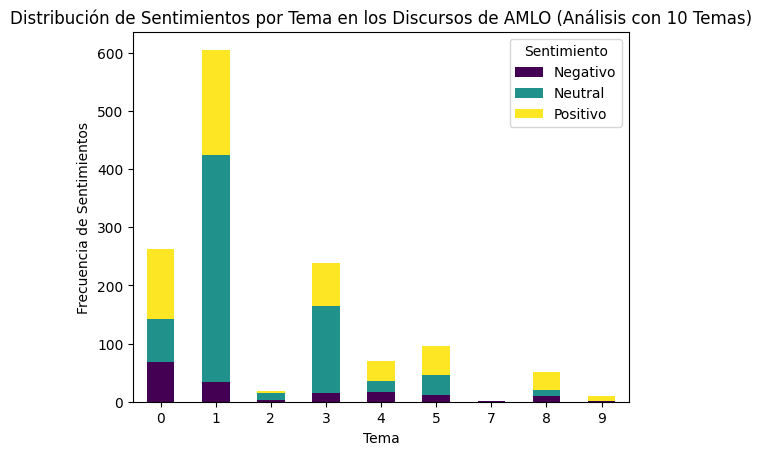

In [ ]:

# Frecuencia de sentimientos por tema con 10 temas
tema_sentimiento_df_completo = df_discursos_completos.groupby(['Tema', 'Sentimiento']).size().unstack().fillna(0)

# Gráfico de barras apiladas con más temas
plt.figure(figsize=(14, 8))
tema_sentimiento_df_completo.plot(kind='bar', stacked=True, colormap='viridis')
plt.title("Distribución de Sentimientos por Tema en los Discursos de AMLO (Análisis con 10 Temas)")
plt.xlabel("Tema")
plt.ylabel("Frecuencia de Sentimientos")
plt.xticks(rotation=0)
plt.legend(title="Sentimiento")
plt.show()


### Conclusiones del Análisis con 10 Temas


- **Tono General:** Los discursos completos muestran un rango de sentimientos, con predominancia de tonos neutros.
- **Distribución Más Detallada:** Se observa una variabilidad de sentimientos con 10 categorías de temas.
- **Temas Sensibles Identificados:** La distribución de sentimientos negativos y positivos es más visible en temas específicos.


## Mejora: Análisis Adicional y Gráficas Avanzadas

<ipython-input-12-f3a1422858d5>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(frecuencias), y=list(palabras), palette='Blues_d')


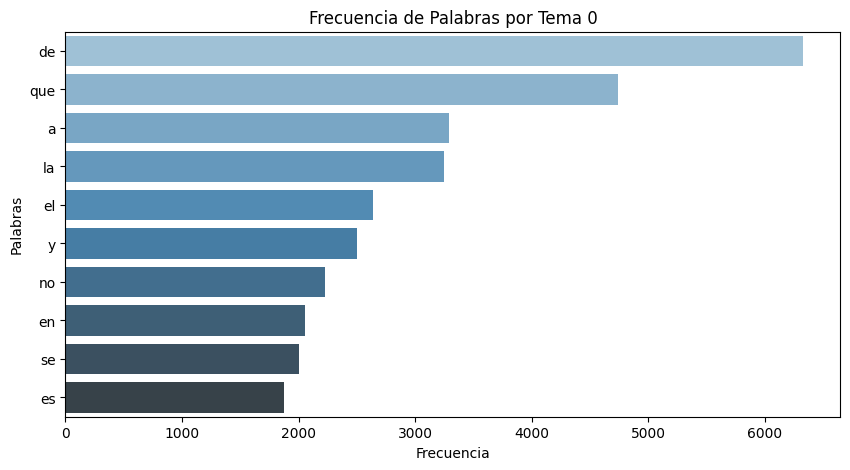

<ipython-input-12-f3a1422858d5>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(frecuencias), y=list(palabras), palette='Blues_d')


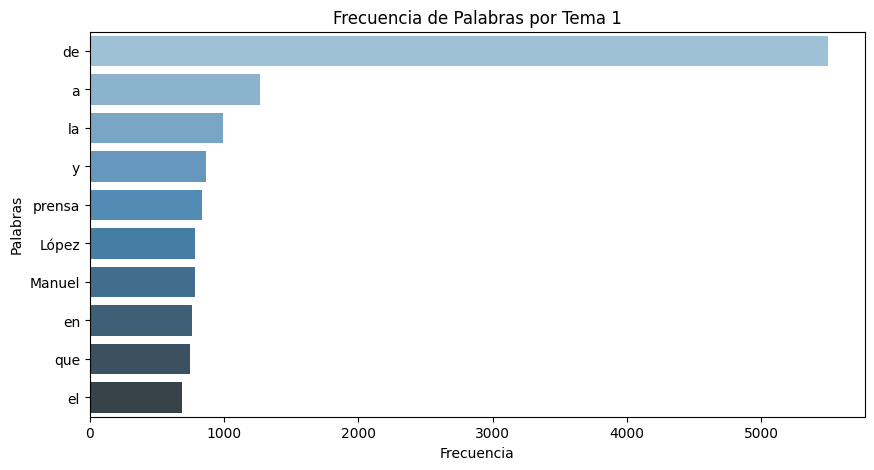

<ipython-input-12-f3a1422858d5>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(frecuencias), y=list(palabras), palette='Blues_d')


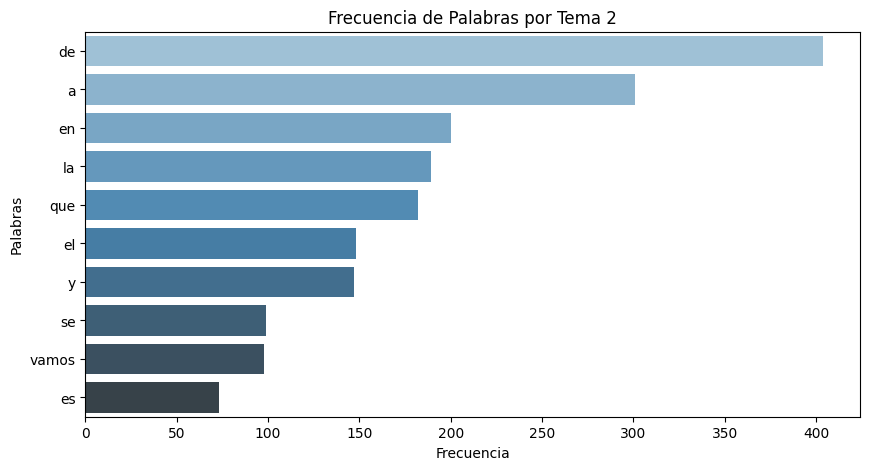

<ipython-input-12-f3a1422858d5>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(frecuencias), y=list(palabras), palette='Blues_d')


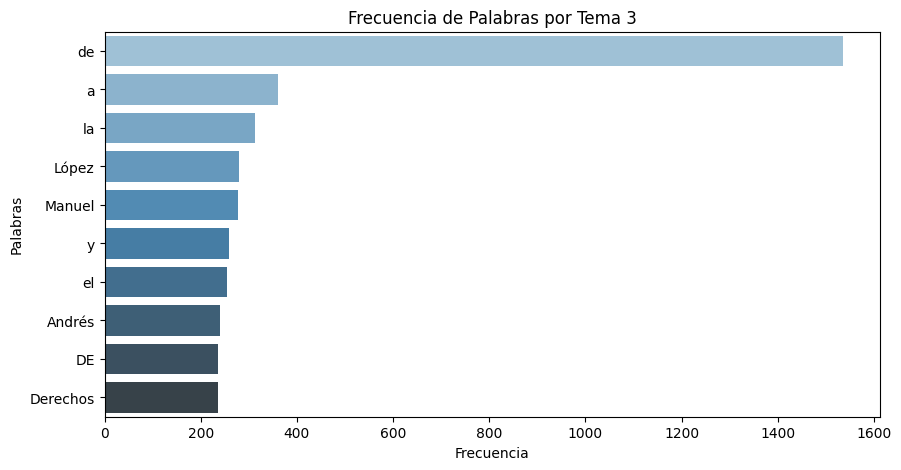

<ipython-input-12-f3a1422858d5>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(frecuencias), y=list(palabras), palette='Blues_d')


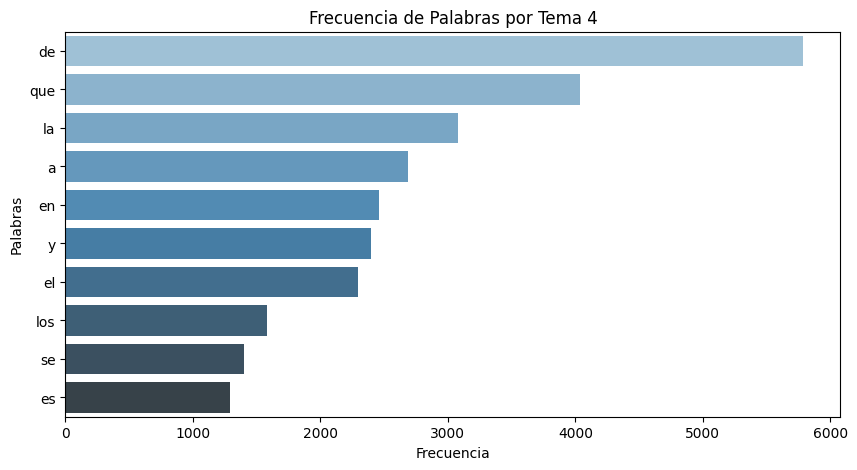

<ipython-input-12-f3a1422858d5>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(frecuencias), y=list(palabras), palette='Blues_d')


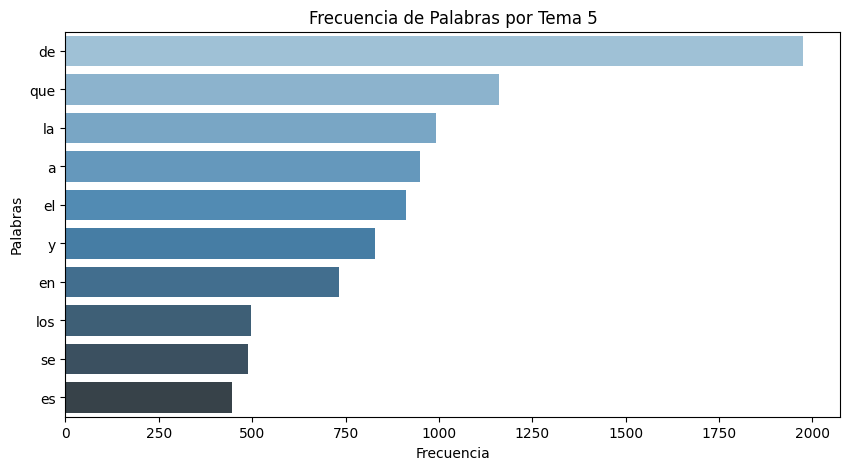

El tema 6 no tiene suficientes palabras para generar el gráfico.


<ipython-input-12-f3a1422858d5>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(frecuencias), y=list(palabras), palette='Blues_d')


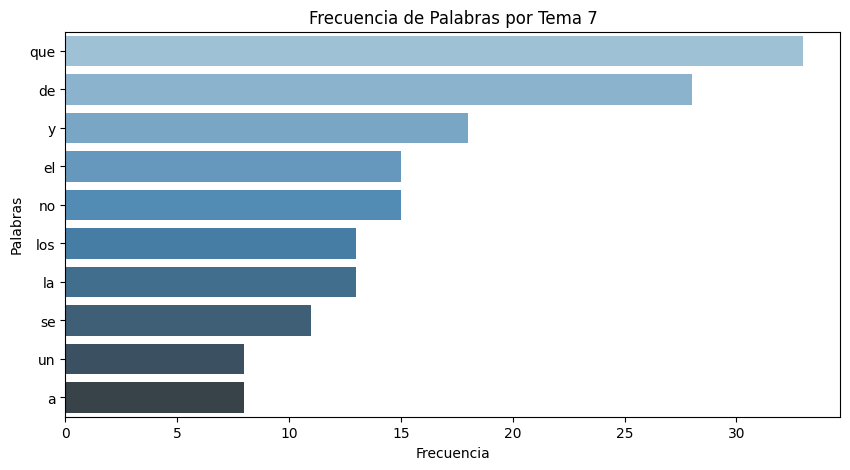

<ipython-input-12-f3a1422858d5>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(frecuencias), y=list(palabras), palette='Blues_d')


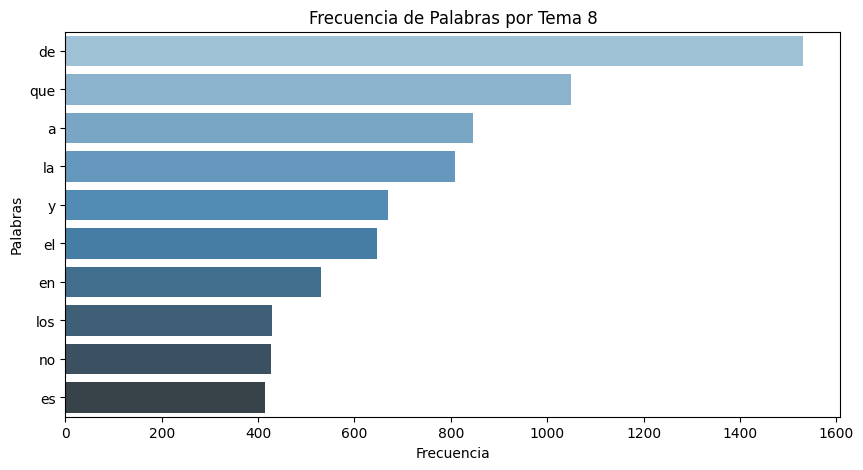

<ipython-input-12-f3a1422858d5>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(frecuencias), y=list(palabras), palette='Blues_d')


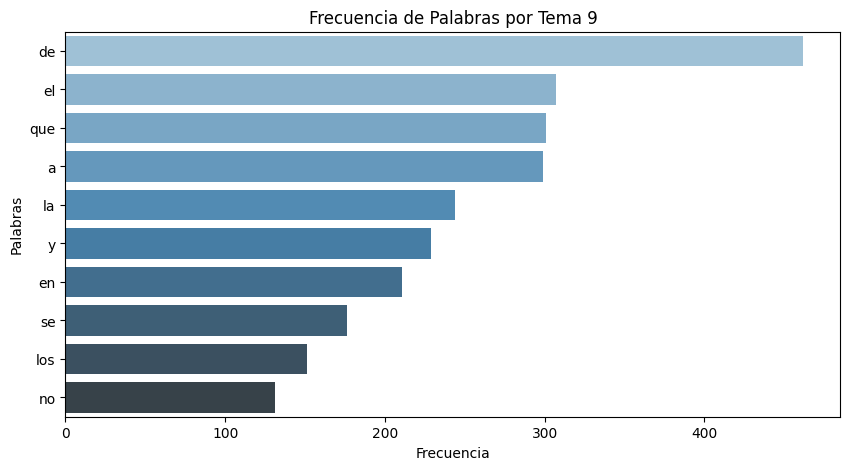

In [ ]:
# Mostrar la frecuencia de palabras en un gráfico
for tema, palabras_frecuencia in frecuencias_palabras.items():
    if len(palabras_frecuencia) > 0:  # Verificar que haya palabras en el tema
        plt.figure(figsize=(10, 5))
        palabras, frecuencias = zip(*palabras_frecuencia)
        sns.barplot(x=list(frecuencias), y=list(palabras), palette='Blues_d')
        plt.title(f'Frecuencia de Palabras por Tema {tema}')
        plt.xlabel('Frecuencia')
        plt.ylabel('Palabras')
        plt.show()
    else:
        print(f"El tema {tema} no tiene suficientes palabras para generar el gráfico.")

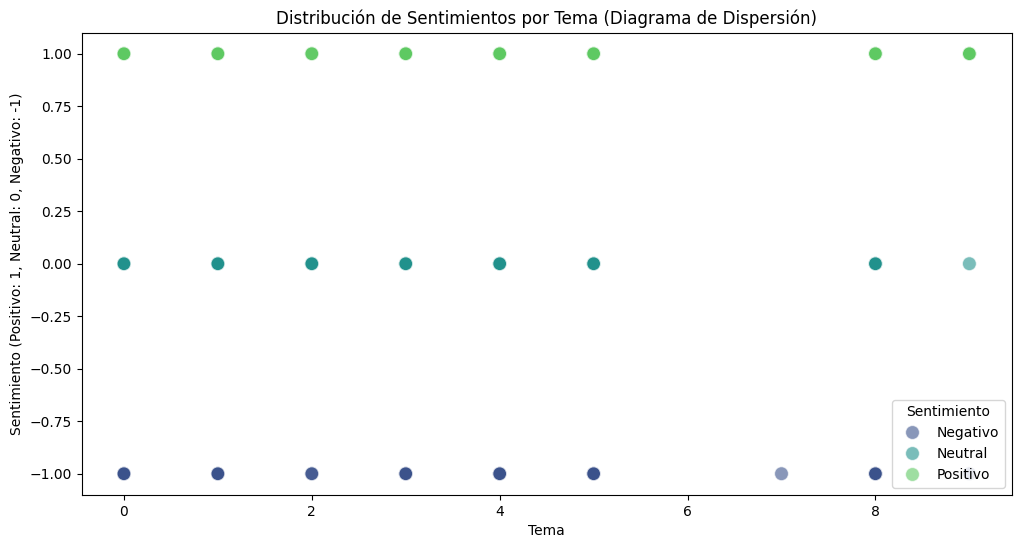

In [ ]:

# Visualización Avanzada: Diagrama de Dispersión para Sentimientos y Temas
import matplotlib.pyplot as plt

# Convertir los sentimientos en valores numéricos para el gráfico
df_discursos_completos['Sentimiento_Num'] = df_discursos_completos['Sentimiento'].map({'Negativo': -1, 'Neutral': 0, 'Positivo': 1})

# Crear el diagrama de dispersión
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Tema', y='Sentimiento_Num', data=df_discursos_completos, hue='Sentimiento', palette='viridis', s=100, alpha=0.6)
plt.title("Distribución de Sentimientos por Tema (Diagrama de Dispersión)")
plt.xlabel("Tema")
plt.ylabel("Sentimiento (Positivo: 1, Neutral: 0, Negativo: -1)")
plt.show()


<ipython-input-10-c774e077e927>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Tema', y='Sentimiento_Num', data=df_discursos_completos, palette='coolwarm')


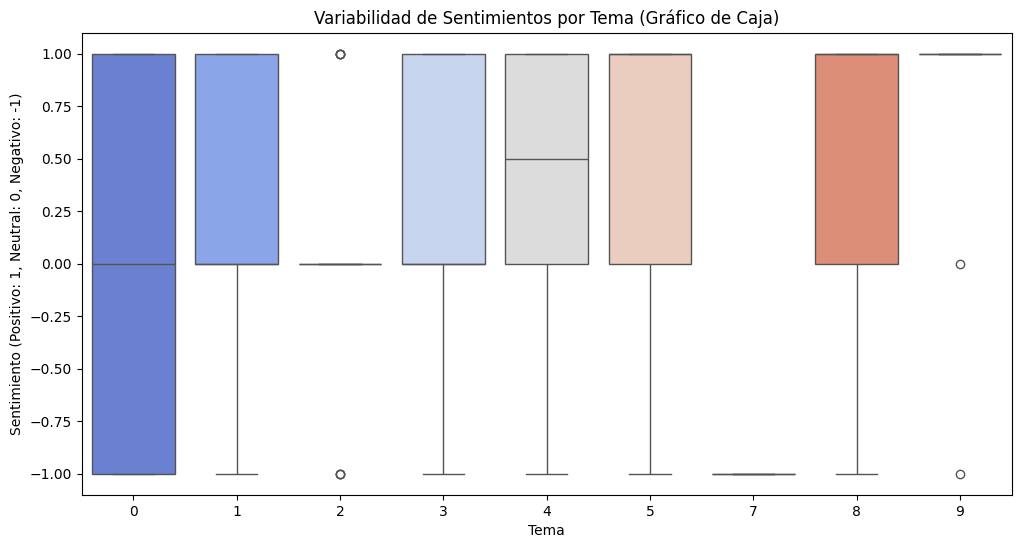

In [ ]:

# Análisis de Variabilidad de Sentimientos en Cada Tema
import matplotlib.pyplot as plt

# Crear un gráfico de caja para mostrar la variabilidad de los sentimientos
plt.figure(figsize=(12, 6))
sns.boxplot(x='Tema', y='Sentimiento_Num', data=df_discursos_completos, palette='coolwarm')
plt.title("Variabilidad de Sentimientos por Tema (Gráfico de Caja)")
plt.xlabel("Tema")
plt.ylabel("Sentimiento (Positivo: 1, Neutral: 0, Negativo: -1)")
plt.show()


In [ ]:
# Mostrar el número total de archivos procesados y sus nombres
num_archivos_procesados = len(internal_files)
print(f"Total de archivos HTML procesados desde el ZIP: {num_archivos_procesados}")

# Mostrar los primeros nombres de archivos procesados
print("Primeros 5 archivos procesados:")
print(internal_files[:5])  # Muestra los primeros 5 nombres de archivos para verificar

# Mostrar el total de discursos extraídos
num_discursos = len(df_discursos_completos)
print(f"Total de discursos extraídos y procesados: {num_discursos}")


Total de archivos HTML procesados desde el ZIP: 1353
Primeros 5 archivos procesados:
['0374.html', '0204.html', '1002.html', '1311.html', '0716.html']
Total de discursos extraídos y procesados: 1353


## Conclusiones Mejoradas


- **Frecuencia de Palabras:** Las palabras más frecuentes ayudan a identificar los términos más usados en cada tema.
- **Diagrama de Dispersión:** Muestra cómo se distribuyen los sentimientos a través de diferentes temas.
- **Gráfico de Caja:** Permite ver la variabilidad de sentimientos dentro de cada tema, mostrando qué tan polarizados están.
